Osnabrück University - Machine Learning (Summer Term 2016) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 08

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, June 12, 2016**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 1: Multilayer Perceptron (MLP) [10 Points]

Last week you implemented a simple perceptron. We discussed that one can use multiple perceptrons to build a network. This week you will build your own MLP. Again the following code cells are just a guideline. If you feel like it, just follow the algorithm steps below in the empty cell - otherwise feel free to use our guided approach again.

### Algorithm: Multilayer Perceptron with Backpropagation

We try to follow the definitions from the lecture (ML-07, Slide 46) closely:

* Layers are numbered from $0$ (input layer) to $L_H + 1$ (output layer), such that $1 \dots L_H$ are hidden layers.
* Each layer has $N(i)$ neurons, numbered from $1 \dots N(i)$.
* $o_i(k)$ is the output of neuron $i$ in layer $k$.
* $w_{ik}(m,n)$ is the weight between neuron $i$ in layer $m$ and neuron $k$ in layer $n$ (where for our case $m = n + 1$ holds).
* The input to the MLP is $x \in \mathbb{R}^{d_{in}} = o(0)$, the output is $y \in \mathbb{R}^{d_{out}} = o(L_H + 1)$.
* $\epsilon$ is the learning rate.

The algorithm you have to implement is now as follows:

1. **Initialize your MLP.** Use as many input neurons as there are dimensions in the data. Input neurons always expect 1D input. Then create neurons for each hidden and the output layer. Each neuron in the hidden and output layers expects as many inputs as there are neurons in the layer before them.
1. **Initialize the neurons' weights.** For each neuron in layers $1 \dots L_H + 1$ initialize the weights to small random values (values between $0$ and $1$ are fine, but you are allowed to tweak the numbers around).
1. **Implement the activation (feed-forward) step.**
    1. Decompose the input into its components and pass them to the correct input neuron.
    1. Each input neuron passes its unprocessed input to the next layer. That means each neuron in layer $1$ receives all outputs from each input layer as its own input.
    $$o_i(0) = x_i$$
    1. Calculate the weighted sums of their inputs and apply their activation function $\sigma$ for each neuron in the layers $1 \dots L_H + 1$. This is best done iteratively layer by layer, as each layer's input is the output of its preceding layer (Note: $w_{j0}(k,k)$ denotes the bias for neuron $j$ in layer $k$):
    $$\begin{align*}
      o_j(k) = \sigma\left(w_{j0}(k,k)+\sum\limits_{i=1}^{N(k-1)} 
              o_i(k-1) w_{ji}(k,k-1)\right)
    \end{align*}$$
    with 
    $$\sigma(x) = \frac{1}{1 + \exp{(-x)}}$$
    1. The resulting $o_i(L_H+1)$ are the outputs $y_i$ for each output neuron $i$.
1. **Implement the adaption (backpropagation) step.**
    1. Compute the error between the target and output components to calculate the error signals $\delta_i(L_H+1)$:
    $$\begin{align*}
      \delta_i(L_H + 1) &= o_i(L_H+1)\ (1 - o_i(L_H+1))\ (t_i - o_i(L_H + 1))
    \end{align*}$$
    1. Calculate the error signals $\delta_i(k)$ for each hidden layer $k$, starting with $k=L_H$ and going down to $k=1$.
    $$\begin{align*}
    \delta_i(k) &= o_i(k)\ (1 - o_i(k))\ \sum\limits_{j=1}^{N(k+1)} w_{ji}(k+1,k)\delta_j(k+1)
    \end{align*}$$
    1. Adapt the weights for each neuron in the hidden and output layers.
    $$\Delta w_{ji}(k+1, k) = \epsilon\, \delta_j(k+1)\, o_i(k)$$

### Custom Approach

Use this to implement and test your own version of an MLP. You are of course allowed to structure the code into more cells, use code from below etc.

In [45]:
import sys
import numpy as np
from scipy.special import expit as act_fun

# Your code goes here:

def init_weights(layers):
    """Initialize weights."""
    return [np.eye(layers[0], layers[0] + 1, 1)] \
         + [np.random.rand(layers[i], layers[i - 1] + 1) for i in range(1, len(layers))]

def feedforward(X, weights):
    """Feedforward"""
    outputs = [weights[0] @ np.append(1, X)]
    for l, layer in enumerate(weights[1:]):
        outputs.append(act_fun(layer @ np.append(1, outputs[l])))
    return outputs

def propagate_backward(outputs, weights, t, epsilon):
    """Backpropagation"""
    weights = np.copy(weights)
    
    # Calculate deltas.
    deltas = [outputs[-1] * (1 - outputs[-1]) * (t - outputs[-1])]
    for k in range(len(outputs) - 1, 1, -1):
        derivative = outputs[k-1] * (1 - outputs[k-1])
        partial_error = np.sum(weights[k] * deltas[0][:,np.newaxis], 0)
        deltas.insert(0, derivative * partial_error[1:])

    # Adjust weights.
    for l, layer in enumerate(weights[1:]):
        layer += (deltas[l] * outputs[l + 1] * epsilon)[:, np.newaxis]
    
    return weights

def train(D, T, weights, epsilon, epochs, samples):
    """Training"""
    weights = np.copy(weights)
    print('Training {} epochs with {} samples each.'.format(epochs, samples))
    for epoch in range(epochs):
        if ((epoch + 1) % 100) == 0:
            sys.stdout.write('.\n' if ((epoch + 1) % 2000) == 0 else '.'); sys.stdout.flush()
        for index in np.random.choice(range(len(D)), samples, replace=False):
            weights = propagate_backward(feedforward(D[index], weights), weights, T[index], epsilon)
    print('Finished.')
    return weights

def test(D, T, weights):
    """Test"""
    error = 0
    for i, d in enumerate(D):
        error += np.abs(feedforward(d, weights)[-1] - T[i])
    return error / len(T)

In [59]:
# Parameters.
data_samples = 400
input_dim = 4
output_dim = 1

# Generate data.
D = np.load('./spaces/m_rost_body_space.npy')
print(D.shape)
T_0 = np.ones(200)
T_1 = np.zeros(200)
T = np.concatenate((T_0,T_1))
print(T.shape)

layers = [input_dim, 2, 2, output_dim]
epsilon = 0.03
epochs = 1000
sample_size = 20


# Initialize weights.
weights = init_weights(layers)

# Train network.
weights = train(D, T, weights, epsilon, epochs, sample_size)

# Test network.
error = test(D, T, weights)
print('Error is', error)

(400, 4)
(400,)
Training 1000 epochs with 20 samples each.
..........Finished.
Error is [0.5]


### Guided Approach
In the following there are multiple cells with code, most of them are there to make the exercise easier. All functions and methods come with a docstring (roughly inspired by the [Google guidelines](https://google.github.io/styleguide/pyguide.html?showone=Comments#Comments) for Python), read them to get a better idea of what the functions are doing. They usually explain what the function does, what input argumens (`Args:`) it expects and what return values (`Returns:`) you can use.

The first cell generates random three dimensional data (= $\text{input_dim}$) between 0 and 1 and labels all data according to a binary classification: If the sum of a data point's components is bigger than $0.7 \cdot \text{input_dim}$ the data point belongs to one class, otherwise to the other. 

The second cell is a simple plot to give you an idea of how this looks like. By now you probably already figured out whether this task can be done with a simple perceptron or not. If you didn't, run the first and second cell and take a closer look at the data.

In [48]:
import numpy as np

# Generate some data.
ND = 400
input_dim = 4
D = np.random.rand(ND, input_dim)
# Label data: sum should be > 0.7 * dim.
T = (np.sum(D, 1) > 0.7 * input_dim) * 1

<IPython.core.display.Javascript object>


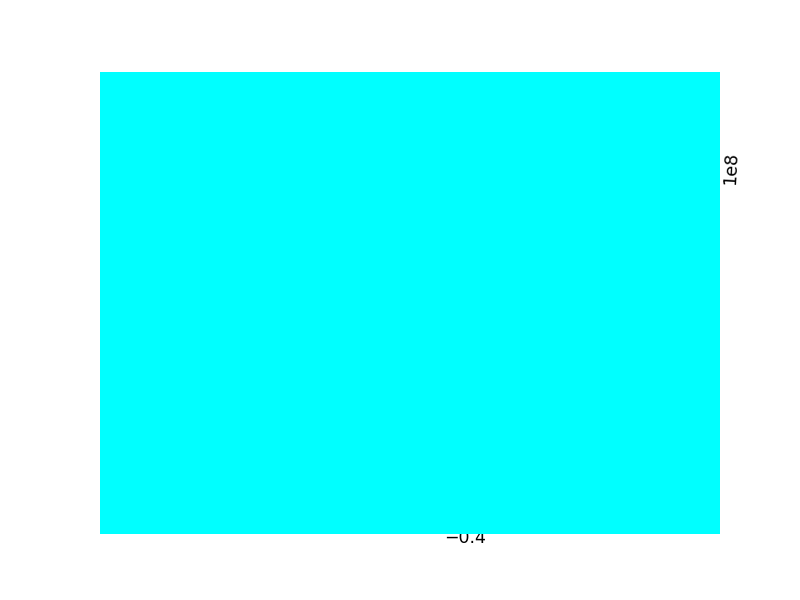

C:\Users\Acer\Anaconda3\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [62]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.figure().add_subplot(111, projection='3d').set_title('Data D')
for t, c in [(0, 'cyan'), (1, 'orange')]:
    x, y, z = tuple(zip(*D[T==t]))
    plt.scatter(x, y, z ,zs=z, c=c)

The following cell provides two functions: One to train your perceptron, one to test it. They will be used further below, but their explanations will give you an idea of what you are supposed to implement.

In [63]:
import sys
import numpy as np

def train_perceptron(perceptron, D, T, epochs, sample_size, verbose=True):
    """
    Trains the perceptron over epochs epochs with sample_size 
    random samples drawn from D. No replacement is done in one epoch.
    
    Args:
        perceptron  The perceptron. Must implement a function
                    adaption(X, t) where X is a row of D and t
                    is its label.
        D           The data of size N x d where N is the
                    number of samples and d is the number
                    of dimensions.
        T           The training labels. Iterable with
                    N x do elements where N is the number
                    of samples in D and do is the dimension
                    of the perceptrons output.    
        epochs      The number of training epochs.
        sample_size The number of random samples per epoch.
        verbose     Prints status messages if True (default).
    """
    if verbose:
        print('Training {}\nEpochs: {}\nSamples per Epoch: {}'.format(perceptron, epochs, sample_size))
    for epoch in range(epochs):
        if verbose:
            sys.stdout.write("\rEpoch {:5d}, {:7.2%}".format(epoch + 1, (epoch + 1) / epochs))
            sys.stdout.flush()
        sample_indices = np.random.choice(range(len(D)), sample_size, replace=False)
        for index in sample_indices:
            x = D[index]
            t = T[index]
            perceptron.adaption(x, t)
    if verbose:
        print('\nFinished.')

def test_perceptron(perceptron, D, T, verbose=True):
    """
    Tests the perceptron on all provided data.
    
    Args:
        perceptron  The perceptron. Must implement a function
                    activation(X) where X is a row of D.
        D           The data of size N x d where N is the
                    number of samples and d is the number
                    of dimensions.
        T           The training labels. Iterable with
                    N x do elements where N is the number
                    of samples in D and do is the dimension
                    of the perceptrons output.
        verbose     Prints status messages if True (default).
    Returns:
        The absolute error per output component.
    """
    if verbose:
        print('Testing {}'.format(perceptron))
    error = 0
    for i, t in enumerate(T):
        error += np.abs(t - perceptron.activation(D[i])) / len(D)
    if verbose:
        print('Total error:', error)
    return error

Here is an implementation of a simple perceptron. It provides an initialization method `__init__(dimensions, epsilon)`, an activation method `activation(X)` and an adaption method `adaption(X, t)` (the method `__repr__()` will be used if you `print(p)` the perceptron). You will use this perceptron as a starting point and overwrite certain methods with your own. This will be done by a programming principle called *inheritance*.

In [64]:
import numpy as np

class BasePerceptron:
    """
    A simple perceptron implementation.
    """

    def __init__(self, dimensions=100, epsilon=0.03):
        """
        Initializes the perceptron. Creates dimensions + 1
        random weights (the additional weight is the bias.)

        Args:
            dimensions  the data dimensionality N
            epsilon     the learning rate
        """
        self.w = np.random.rand(dimensions + 1)
        self.epsilon = epsilon

    def activation(self, X):
        """
        The activation function. Prepends a 1 to X for the
        bias and calculates the activation function of the 
        perceptron.

        Args:
            X   the data point, should be a numpy
                array or a 1xN numpy matrix
        Returns:
            1   if the activation of X is bigger than 0
            0   else
        """
        return 1 if np.append(1, X) @ self.w > 0 else 0

    def adaption(self, X, t):
        """
        Trains the perceptron. Adjusts the weights according to 
        the learning rate and the error between the activation and the 
        label (delta).

        Args:
            X   the data point, should be a numpy
                array or a 1xN numpy matrix
            t   the label
        """
        self.w += self.epsilon * (t - self.activation(X)) * np.append(1, X)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, len(self.w) - 1, self.epsilon)

This cell instantiates a BasePerceptron (`input_dim` is taken from above, where the data is created) and trains and tests it. The multilayer perceptron will behave exactly the same.

In [65]:
# Instantiate a perceptron.
epsilon = 0.03
perceptron = BasePerceptron(input_dim, epsilon)

# Train and test the perceptron for data D.
train_perceptron(perceptron, D, T, epochs=100, sample_size=20)
print()
_ = test_perceptron(perceptron, D, T)

Training BasePerceptron(4, 0.03)
Epochs: 100
Samples per Epoch: 20
Epoch   100, 100.00%
Finished.

Testing BasePerceptron(4, 0.03)
Total error: 0.5000000000000003


In order to implement the MLP you need two basic building blocks: Input neurons and neurons for the hidden layers. Below there are two unfinished class definitions which inherit from the `BasePerceptron`. That means, that they have the exact same methods already available! This is cool, as you don't need to implement your own initialization or `__repr__` functions.

Note however, that some methods are *redefined*. We adjusted the documentation for you, but we just copied the original code. 

One big difference between the `BasePerceptron` and the `InputPerceptron` and `ContinuousPerceptron` is, that the `BasePerceptron` is used by the functions provided above, while the `InputPerceptron` and `ContinuousPerceptron` are used by the `MultilayerPerceptron` which comes next.

To implement these classes it might be needed that you get a better understanding of how they are used: If you don't figure out directly how they should work, continue with the `MultilayerPerceptron` below and come back whenever you need to.

Below the `MultilayerPerceptron` there is a cell to test your implementation. You might want to change the number of neurons per (hidden) layer to see how your MLP handles it.

**The algorithm again**
This is just a copy of the algorithm above so that you have it close by while implementing the next few classes.

1. **Initialize your MLP.** Use as many input neurons as there are dimensions in the data. Input neurons always expect 1D input. Then create neurons for each hidden and the output layer. Each neuron in the hidden and output layers expects as many inputs as there are neurons in the layer before them.
1. **Initialize the neurons' weights.** For each neuron in layers $1 \dots L_H + 1$ initialize the weights to small random values (values between $0$ and $1$ are fine, but you are allowed to tweak the numbers around).
1. **Implement the activation (feed-forward) step.**
    1. Decompose the input into its components and pass them to the correct input neuron.
    1. Each input neuron passes its unprocessed input to the next layer. That means each neuron in layer $1$ receives all outputs from each input layer as its own input.
    $$o_i(0) = x_i$$
    1. Calculate the weighted sums of their inputs and apply their activation function $\sigma$ for each neuron in the layers $1 \dots L_H + 1$. This is best done iteratively layer by layer, as each layer's input is the output of its preceding layer (Note: $w_{j0}(k,k)$ denotes the bias for neuron $j$ in layer $k$):
    $$\begin{align*}
      o_j(k) = \sigma\left(w_{j0}(k,k)+\sum\limits_{i=1}^{N(k-1)} 
              o_i(k-1) w_{ji}(k,k-1)\right)
    \end{align*}$$
    with 
    $$\sigma(x) = \frac{1}{1 + \exp{(-x)}}$$
    1. The resulting $o_i(L_H+1)$ are the outputs $y_i$ for each output neuron $i$.
1. **Implement the adaption (backpropagation) step.**
    1. Compute the error between the target and output components to calculate the error signals $\delta_i(L_H+1)$:
    $$\begin{align*}
      \delta_i(L_H + 1) &= o_i(L_H+1)\ (1 - o_i(L_H+1))\ (t_i - o_i(L_H + 1))
    \end{align*}$$
    1. Calculate the error signals $\delta_i(k)$ for each hidden layer $k$, starting with $k=L_H$ and going down to $k=1$.
    $$\begin{align*}
    \delta_i(k) &= o_i(k)\ (1 - o_i(k))\ \sum\limits_{j=1}^{N(k+1)} w_{ji}(k+1,k)\delta_j(k+1)
    \end{align*}$$
    1. Adapt the weights for each neuron in the hidden and output layers.
    $$\Delta w_{ji}(k+1, k) = \epsilon\, \delta_j(k+1)\, o_i(k)$$

In [66]:
class InputPerceptron(BasePerceptron):
    """
    InputPerceptron inherits all properties of the 
    BasePerceptron but implements a new activation function:
    Instead of just using a threshold, it ignores its 
    weights and just passes on its input.
    """

    def activation(self, X):
        """
        The activation function for input perceptrons is
        the identity function.

        Args:
            X           the data point
        Returns:
            X
        """
        # TODO: Change this method.
        return X

In [67]:
import numpy as np
import scipy.special

class ContinuousPerceptron(BasePerceptron):
    """
    ContinuousPerceptron inherits all properties of the 
    BasePerceptron but implements a new activation function:
    Instead of just using a threshold, the continuous perceptron
    uses a sigmoid function.
    """

    def activation(self, X):
        """
        The activation function. Prepends a 1 to X for the
        bias and calculates the activation function of the 
        perceptron.

        Args:
            X           the data point, should be a numpy
                        array or a 1xN numpy matrix
        Returns:
            1 / (1 + exp( -y ))
            where y is the dot product of the weights and 
            the padded input.
        """
        # TODO: Change this method.
        return scipy.special.expit(self.w @ np.append(1, X))

    def adaption(self, X, t):
        """
        Trains the perceptron. Adjusts the weights according to 
        the learning rate and the error between the activation and the 
        label (delta).

        Args:
            X   the input to this perceptron
            t   the delta
        """
        # TODO: Change this method.
        self.w += self.epsilon * t * np.append(1, X)

In [68]:
import numpy as np

class MultilayerPerceptron:
    def __init__(self, dimensions=[2, 1, 1], epsilon=0.03):
        """
        Initializes a multilayer perceptron.
        
        The argument dimensions denotes the number of neurons 
        per layer. The default is [2, 1, 1], which means that
        there are 2 InputPerceptrons in the input layer, 
        1 ContinuousPerceptron in the first hidden layer and 
        also 1 ContinuousPerceptron in the output layer.
        
        Epsilon is passed on to all neurons in the MLP (except
        for the input layer).
        
        The layers are stored as one list per layer containing
        its neurons. All layers are stored in a list self.layers.
        
        Example:
        self.layers = [[input neurons],
                       [neurons of layer 1],
                       [neurons of layer 2],
                       [neurons of layer 3],
                       [output neurons]]
        
        Args:
            dimensions  A list of integers denoting the number 
                        of neurons per layer. The first integer
                        denotes the number of input neurons,
                        the last the number of output neurons.
                        All integers in between denote neurons
                        per hidden layer.
            epsilon     The learning rate passed on to each neuron.
        """
        self.layers = []
        self.epsilon = epsilon

        # Create input layer.
        self.layers.append([InputPerceptron(1, 0) for i in range(dimensions[0])])

        # Generate hidden and output layers.
        dim = len(self.layers[0])
        for N in dimensions[1:]:
            layer = [ContinuousPerceptron(dim, epsilon) for i in range(N)]
            self.layers.append(layer)
            dim = N

        # Initialize outputs and deltas.
        self.outputs = []
        self.deltas = []

    def activation(self, X):
        """
        Implements the activation step (feed forward).
        
        Calculates the outputs for each layer by calling the 
        respective activation methods and stores the results
        in a list of lists self.outputs such that
        self.outputs[k][i] is the output of neuron self.layers[k][i]
        where k is the layer and i is the i-th neuron of that layer.
        
        Args:
            X   the input data
        
        Returns:
            the network output, i.e. the outputs of the output layer.
        """
        # Clear potentially stored outputs.
        self.outputs = []

        # Activate input layer and store its outputs.
        layer_outputs = np.array([self.layers[0][i].activation(x) for i, x in enumerate(X)])

        self.outputs.append(layer_outputs)

        # Activate all other layers with the outputs from before.
        for layer in self.layers[1:]:
            layer_outputs = np.array([layer[j].activation(layer_outputs) for j in range(len(layer))])
            self.outputs.append(layer_outputs)

        # Return the last outputs for the output layer.
        return np.copy(layer_outputs)

    def adaption(self, X, t):
        """
        Implements the adaption step (backpropagation).

        Calls self.activation(X) to make sure the outputs are set
        properly.
        
        Calculates the error signals for the output layer and 
        from there on calculates the error signals for each hidden 
        layer, starting with the last.
        
        Then adjusts each hidden and output neuron's weights by 
        calling the respective adaption functions.
        
        Args:
            X   the data point
            t   the label (must fit the number of output components)
        """
        # Clear potentially stored deltas.
        self.deltas = [0] * len(self.layers)

        # Activate perceptron to figure out and store each
        # neuron's output.
        outputs = self.activation(X)
        
        # Calculate deltas for output layers.
        self.deltas[-1] = (t - self.outputs[-1]) * self.outputs[-1] * (1 - self.outputs[-1])

        # Calculate deltas for other layers.
        for k in range(len(self.layers) - 2, 0, -1):
            self.deltas[k] = [0] * len(self.layers[k])
            for i in range(len(self.layers[k])):
                # Collect weights from layer k + 1.
                weights = np.array([n.w[i] for n in self.layers[k + 1]])
                # Calculate deltas.
                self.deltas[k][i] = weights @ self.deltas[k + 1] * self.outputs[k][i] * (1 - self.outputs[k][i])
        
        # Adapt weights.
        for k, layer in enumerate(self.layers):
            # Skip input layer.
            if k == 0:
                continue
            for i, neuron in enumerate(layer):
                neuron.adaption(self.outputs[k - 1], self.deltas[k][i])

    def __repr__(self):
        return 'MultiLayerPerceptron({}, {})'.format([len(l) for l in self.layers], self.epsilon)

    def __str__(self):
        return '\n\t'.join([repr(self)] + [str(l) for l in self.layers])

In [69]:
# Instantiate a multilayer perceptron.
epsilon = 0.03
output_dim = 1
layers = [input_dim, 2, 2, output_dim]
perceptron = MultilayerPerceptron(layers, epsilon)
# Train and test the perceptron for data D.
train_perceptron(perceptron, D, T, epochs=100, sample_size=20)
print()
_ = test_perceptron(perceptron, D, T)

Training MultiLayerPerceptron([4, 2, 2, 1], 0.03)
	[InputPerceptron(1, 0), InputPerceptron(1, 0), InputPerceptron(1, 0), InputPerceptron(1, 0)]
	[ContinuousPerceptron(4, 0.03), ContinuousPerceptron(4, 0.03)]
	[ContinuousPerceptron(2, 0.03), ContinuousPerceptron(2, 0.03)]
	[ContinuousPerceptron(2, 0.03)]
Epochs: 100
Samples per Epoch: 20
Epoch   100, 100.00%
Finished.

Testing MultiLayerPerceptron([4, 2, 2, 1], 0.03)
	[InputPerceptron(1, 0), InputPerceptron(1, 0), InputPerceptron(1, 0), InputPerceptron(1, 0)]
	[ContinuousPerceptron(4, 0.03), ContinuousPerceptron(4, 0.03)]
	[ContinuousPerceptron(2, 0.03), ContinuousPerceptron(2, 0.03)]
	[ContinuousPerceptron(2, 0.03)]
Total error: [0.5]


## Assignment 2: MLP and RBFN [10 Points]

This exercise is aimed at deepening the understanding of Radial Basis Function Networks and how they relate to Multilayer Perceptrons. Not all of the answers can be found directly in the slides - so when answering the (more algorithmic) questions, first take a minute and think about how you would go about solving them and if nothing comes to mind search the internet for a little bit. If you are interested in a real life application of both algorithms and how they compare take a look at this paper: [Comparison between Multi-Layer Perceptron and Radial Basis Function Networks for Sediment Load Estimation in a Tropical Watershed](http://file.scirp.org/pdf/JWARP20121000014_80441700.pdf)

![Schematic of a RBFN](RBFN.png)

We have prepared a little example that shows how radial basis function approximation works in Python. This is not an example implementation of a RBFN but illustrates the work of the hidden neurons.

<IPython.core.display.Javascript object>


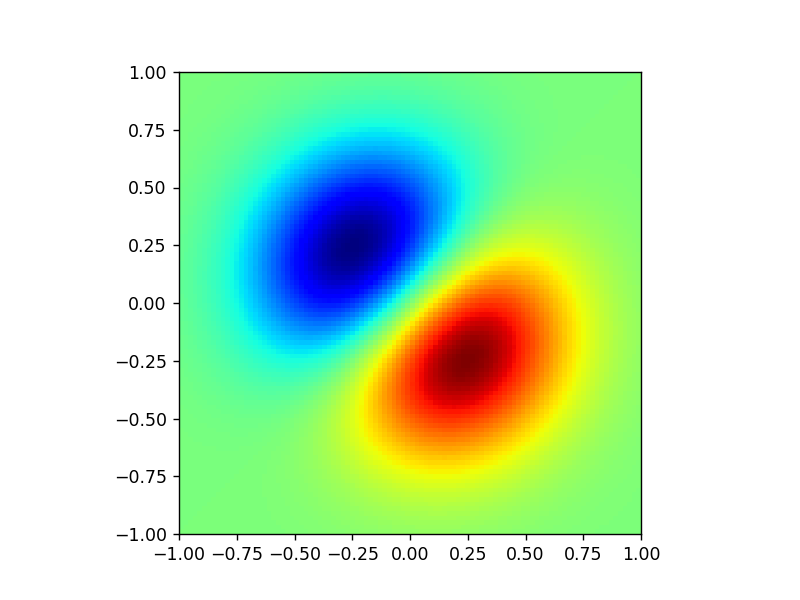

<IPython.core.display.Javascript object>


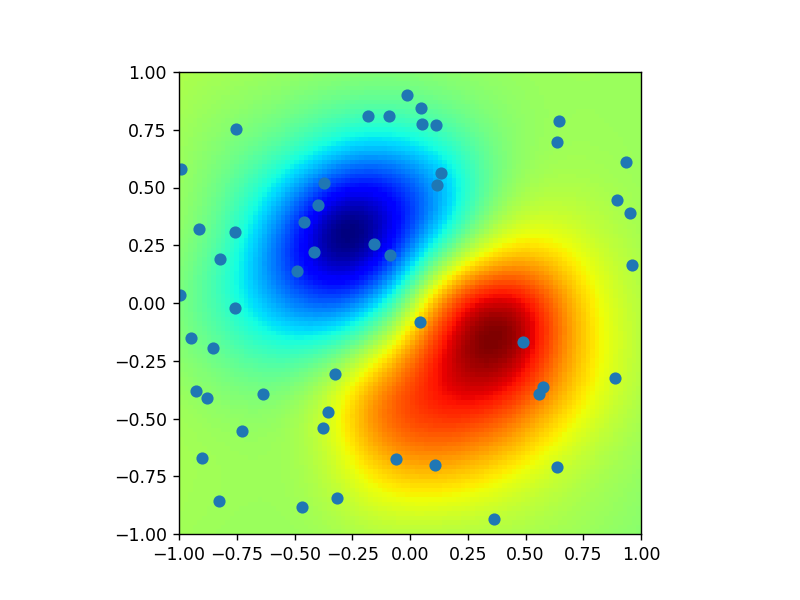

In [70]:
%matplotlib notebook

import numpy as np
from numpy.random import uniform

from scipy.interpolate import Rbf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm


def func(x,y):
    '''
    This is the example function that should be fitted.
    Its shape could be described as two peaks close to
    each other - one going up, the other going down
    '''
    return (x + y) * np.exp(-4.0 * (x**2 + y**2))

# number of training points (you may try different values here)
training_size = 50

# sample 'training_size' data points from the input space [-1,1]x[-1,1] ...
x = uniform(-1.0, 1.0, size=training_size)
y = uniform(-1.0, 1.0, size=training_size)

# ... and compute function values for them.
fvals = func(x, y)

# get the aprroximation via RBF
new_func = Rbf(x, y, fvals)


# Plot both functions: 
# create a 100x100 grid of input values
x_grid, y_grid = np.mgrid[-1:1:100j, -1:1:100j]

plt.figure("Original Function")
# This plot represents the original function
f_orig = func(x_grid, y_grid)
plt.imshow(f_orig, extent=[-1,1,-1,1], cmap=plt.cm.jet)

plt.figure("RBF Result")
# This plots the approximation of the original function by the RBF
# if the plot looks strange try to run it again, the sampling
# in the beginning is random
f_new = new_func(x_grid, y_grid)
plt.imshow(f_new, extent=[-1,1,-1,1], cmap=plt.cm.jet)
plt.xlim(-1,1)
plt.ylim(-1,1)
# scatter the datapoints that have been used by the RBF
plt.scatter(x, y)

### Radial Basis Function Networks

#### What are radial basis functions?

Radial basis functions are all functions that fullfill the following criteria:

The value of the function for a certain point depends only on the distance of that point to the origin or some other fixed center point. In mathematical formulation that spells out to: 
$\phi (\mathbf {x} )=\phi (\|\mathbf {x} \|)$  or  $\phi (\mathbf {x} ,\mathbf {c} )=\phi (\|\mathbf {x} -\mathbf {c} \|)$. Notice that it is not necessary (but most common) to use the norm as the measure of distance.

#### What is the structure of a RBFN? You may also use the notion from the above included picture.

RBFN's are networks that contain only one hidden layer. The input is connected to all the hidden units. Each of the hidden units has a different radial basis function that is *sensitive* to ranges in the input domain. The output is then a linear combination of the outpus ot those functions.

#### How is a RBFN trained?

Note: all input data has to be normalized.

Training a RBFN is a two-step process. First the functions in the hidden layer are initialized. This can be either done by sampling from the input data or by first performing a k-means clustering, where k is the number of nodes that have to be initialzed.

The second step fits a linear model with coefficients $w_{i}$ to the hidden layer's outputs with respect to some objective function. The objective function depends on the task: it can be the least squares function, or the weights can be adapted by gradient descent.

### Comparison to the Multilayer Perceptron

#### What do both models have in common? Where do they differ?

|RBFN                 |MLP                  | 
|---------------------|---------------------|
| non-linear layered feedforward network|non-linear layered feedforward network| 
| hidden neurons use radial basis functions, output neurons use linear function| input, hidden and output-layer all use the same activation function| 
| universal approximator |   universal approximator |
| learning usually affects only one or some RBF | learning affects many weights throught the network|

#### How can classification in both networks be visualized?

![Classification](Solution_Classification.png)

#### When would you use a RBFN instead of a Multilayer Perceptron?

RBFNs are more robust to noise and should therefore be used when the data contains false-positives.